Data Augmentation utilities for other notebooks. We distinguish:

* **offline** data augmentation: the dataset is augmented *before* training cycle and used entirely for the whole training process;
* **online** data augmentation: at each training step, each retrieved minibatch is augmented *separately* by a dedicated `keras` layer.

In [ ]:
%cd "/content/drive/MyDrive/Colab Notebooks"

/content/drive/MyDrive/Colab Notebooks


In [ ]:
!pip install keras_cv

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import numpy as np
import cv2
from PIL import Image
import os
import PIL
import tensorflow as tf
import keras_cv
import tensorflow_datasets as tfds
import glob
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import json
import random

In [ ]:
%run utils.ipynb

/content/drive/MyDrive/Colab Notebooks


## Data Augmentation

We implement the following:
* Brightness change
* Saturation change
* Inversion (whole image)
* Gaussian Noise
* Salt & Pepper
* Horizontal Flip

### Offline Data Augmentation

In [ ]:
def apply_brightness_change(images, tip_pos=None, delta=0.1):
  new_images = tf.image.adjust_brightness(images, delta).numpy()
  return new_images, (tip_pos.copy() if tip_pos is not None else None)

def apply_saturation_change(images, tip_pos=None, saturation_factor=1):
  new_images = tf.image.adjust_saturation(images, saturation_factor).numpy()
  return new_images, (tip_pos.copy() if tip_pos is not None else None)

def apply_inversion(images, tip_pos=None, prob=0.1):
  if random.random() <= prob:
    new_images = 1.0 - images
    return new_images, (tip_pos.copy() if tip_pos is not None else None)
  else:
    return images.copy(), (tip_pos.copy() if tip_pos is not None else None)

def apply_gaussian_noise(images, tip_pos=None, sigma=0.1):
  new_images = images.copy() + (sigma ** 2) * np.random.randn(*images.shape)
  return new_images, (tip_pos.copy() if tip_pos is not None else None)

def apply_horizontal_flip(images, tip_pos):
  flipped_images = np.flip(images, axis=2)
  flipped_tip_pos = tip_pos.copy()
  flipped_tip_pos[:, 1] = -flipped_tip_pos[:, 1]
  return flipped_images, flipped_tip_pos

def apply_salt_and_pepper(images, tip_pos=None, prob=0.1):
  '''
  Add salt and pepper noise to image
  :param prob: Probability of the noise
  '''
  new_images = np.zeros(images.shape,np.float32)
  thres = 1 - prob
  randoms = np.zeros_like(images)
  randoms[:, :, :, 0] = np.random.uniform(0., 1., size=images.shape[:-1])
  randoms[:, :, :, 1] = randoms[:, :, :, 0]
  randoms[:, :, :, 2] = randoms[:, :, :, 0]
  new_images = (randoms < prob) * 0. + (randoms > thres) * 1. + (prob <= randoms) * (randoms <= thres) * images
  return new_images, (tip_pos.copy() if tip_pos is not None else None)

In [ ]:
def augment_dataset(images, tip_pos, **parameters):
  """
  Augments the dataset by applying specified augmentation functions to the images and tip positions.

  Parameters:
      images (numpy.ndarray): A numpy array of shape (num_images, height, width, channels) representing the original images.
      tip_pos (numpy.ndarray): A numpy array of shape (num_images, 3) representing the original tip positions.
      **parameters: Additional keyword arguments specifying the augmentation functions and their parameters.

  Returns:
      tuple: A tuple containing two elements:
          - augmented_images (numpy.ndarray): A numpy array of shape (num_augmented_images, height, width, channels) representing the augmented images.
          - augmented_tip_pos (numpy.ndarray): A numpy array of shape (num_augmented_images, 3) representing the augmented tip positions.

  """
  new_data = [images]
  new_labels = [tip_pos]
  for param_name, param_values in parameters.items():
    func = eval(param_name)
    new_images, new_pos = func(images, tip_pos, **param_values)
    new_data.append(new_images)
    new_labels.append(new_pos)
  return np.row_stack(new_data), np.row_stack(new_labels)

In [ ]:
def get_augmented_dataset(
    image_data_path='data/image/ws_0.5', motion_data_path='data/motion/ws_0.5.npz',
    resize=True, force_resize=True, target_size_perc=0.125, rescale_coordinates=1,
    target_size=None, train_perc=0.6, eval_perc=0.2, test_perc=0.2, **parameters
):
  """
  Returns the augmented dataset with the images and tip positions after applying specified augmentation functions.

  Parameters:
    image_data_path (str): Path to the directory containing the image data. Default is 'data/image/ws_0.5'.
    motion_data_path (str): Path to the motion data file. Default is 'data/motion/ws_0.5.npz'.
    resize (bool): Flag to enable resizing of the images. Default is True.
    force_resize (bool): Flag to force image resizing even if resized images already exist. Default is True.
    target_size_perc (float): Percentage of the target image size relative to the original size. Default is 0.125.
    rescale_coordinates (float): Scaling factor for the tip position coordinates. Default is 1.
    target_size (tuple): Tuple specifying the target height and width of the images. Default is None.
    **parameters: Additional keyword arguments specifying the augmentation functions and their parameters.

  Returns:
    tuple: A tuple containing two elements:
      - augmented_images (numpy.ndarray): A numpy array of shape (num_augmented_images, height, width, channels) representing the augmented images.
      - augmented_tip_pos (numpy.ndarray): A numpy array of shape (num_augmented_images, 3) representing the augmented tip positions.

  """
  images, tip_pos = get_dataset(
      image_data_path, motion_data_path, resize, force_resize, target_size_perc,
      rescale_coordinates, target_size
  )
  (train_images, train_tip_pos), (eval_images, eval_tip_pos), \
    (test_images, test_tip_pos) = holdout_split(
        train_perc, eval_perc, test_perc, images, tip_pos
    )
  train_images, train_tip_pos = augment_dataset(train_images, train_tip_pos, **parameters)
  return (train_images, train_tip_pos), (eval_images, eval_tip_pos), \
    (test_images, test_tip_pos)

### Online Data Augmentation

In [ ]:
from keras import backend as K
class SaltAndPepper(tf.keras.layers.Layer):

    def __init__(self, ratio, **kwargs):
        super(SaltAndPepper, self).__init__(**kwargs)
        self.supports_masking = True
        self.ratio = ratio

    def call(self, inputs, training=True):
        def noised():
            shp = K.shape(inputs)[1:]
            mask_select = K.random_binomial(shape=shp, p=self.ratio)
            mask_noise = K.random_binomial(shape=shp, p=0.5) # salt and pepper have the same chance
            out = inputs * (1-mask_select) + mask_noise * mask_select
            return out

        return K.in_train_phase(noised(), inputs, training=training)

    def get_config(self):
        config = {'ratio': self.ratio}
        base_config = super(SaltAndPepper, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

In [ ]:
def _inversion(prob=0.1,**kwargs):
  if random.random() <= prob:
    return tf.keras.layers.Lambda(lambda x: 1. - x)
  else:
    return None
_NAMES = {
    'apply_brightness_change': tf.keras.layers.RandomBrightness,
    'apply_saturation_change': keras_cv.layers.RandomSaturation,
    'apply_inversion': _inversion,
    'apply_gaussian_noise': tf.keras.layers.GaussianNoise,
    'apply_salt_and_pepper': SaltAndPepper,
}

In [ ]:
def get_data_augmentation_layer(**augmentation_configuration):
  model = tf.keras.Sequential()
  for function_name, function_args in augmentation_configuration.items():
    layer_gen = _NAMES.get(function_name)
    new_layer = layer_gen(**function_args)
    if new_layer:
      model.add(new_layer)
  return model

## Examples

### Offline Data Augmentation

In [ ]:
# An example configuration for augmenting dataset
augmentation_configuration = {
    'apply_brightness_change': {'delta': 0.2},
    'apply_saturation_change': {'saturation_factor': 1},
    'apply_inversion': {'prob': 0.1},
    'apply_gaussian_noise': {'sigma': 0.1},
    'apply_salt_and_pepper': {'prob': 0.1}
}

In [ ]:
images, tip_pos = get_augmented_dataset(
    force_resize=False, rescale_coordinates=100, **augmentation_configuration,
)[0]

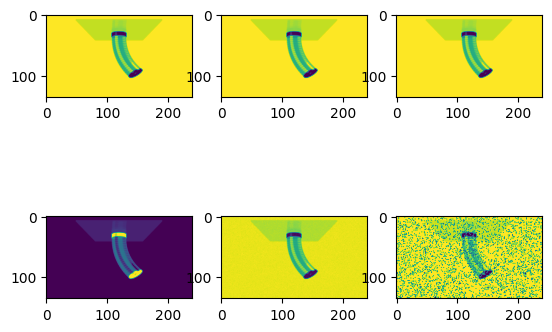

In [ ]:
# Plot examples
IDX = 12
LEN = 307
fig, ax = plt.subplots(2, 3)
plt.imshow(images[0, :, :, 1])
ax[0, 0].imshow(images[IDX, :, :, 1])
ax[0, 1].imshow(images[IDX+LEN, :, :, 1])
ax[0, 2].imshow(images[IDX+2*LEN, :, :, 1])
ax[1, 0].imshow(images[IDX+3*LEN, :, :, 1])
ax[1, 1].imshow(images[IDX+4*LEN, :, :, 1])
ax[1, 2].imshow(images[IDX+5*LEN, :, :, 1])

### Online Data Augmentation

In [ ]:
online_augmentation_configuration = {
    'apply_saturation_change': {'factor': 1},
    'apply_inversion': {'prob': 0.1},
    'apply_gaussian_noise': {'stddev': 0.1},
    'apply_salt_and_pepper': {'ratio': 0.1}
}
data_augmenter = get_data_augmentation_layer(**online_augmentation_configuration)

In [ ]:
new_images = data_augmenter(images[:513])

In [ ]:
print(new_images.shape, type(new_images))

(513, 135, 240, 3) <class 'tensorflow.python.framework.ops.EagerTensor'>


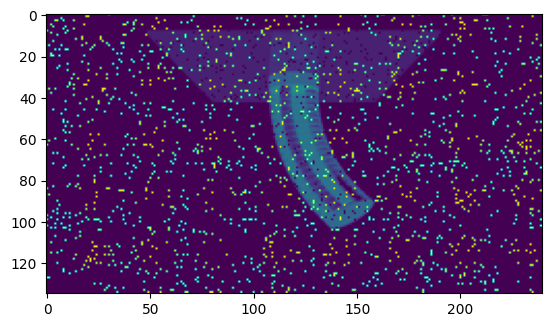

In [ ]:
# Plot examples
IDX = 12
LEN = 513
fig, ax = plt.subplots(1, 1)
plt.imshow(new_images[0, :, :, 1])
ax.imshow(new_images[IDX, :, :, 1])